In [31]:
# Test Data

# Customer locations
DEPOT_LOCATION = (0,0)
CUSTOMERS = [(4, 4), (2, 2), 
             (3, 4)
            ]

# population size -> no of solutions/ individuals in population
POP_SIZE = 50

# number of generations
GEN = 100

# number of vehicles
N_VEHICLES = 2


In [32]:
import numpy as np
import random


# How one individual is defined: [route, vehicles]
# Example [[1, 2, 3, 4]][0,0,1,1]] 
# Customer Locations: 1, 2, 3, 4
# Vehicles: 0, 1
# Vehicle 0 goes to customer location 1 and 2
# Vehicle 1 goes to customer locations 3 and 4

# Representation inspired by and adapted from: 
# https://transport-systems.imperial.ac.uk/tf/60008_21/n6_10_vehicle_routing_problem-genetic_algorithm.html

 
def create_individual():
    vehicle = list(np.random.randint(N_VEHICLES, size=(len(CUSTOMERS))))
    schedule = random.sample(range(len(CUSTOMERS)), len(CUSTOMERS))
    individual = [schedule, vehicle]

    return individual
    

In [119]:
# test individual creation
create_individual()

[[2, 0, 1], [0, 1, 0]]

In [33]:
# calculates distance using Euclidean formula
DEPOT_LOCATION = (0,0)

# function inspired by Lab 1 code

# vehicles start from depot, visit every customer, and then return to depot


def get_distance(route):
    if len(route) == 0:
        return 0

    
    route_str = f"Depot: {DEPOT_LOCATION} -> "
    for i in range(len(route)):
        route_str += f"CUSTOMER {route[i]}: {CUSTOMERS[route[i]]}-> "
    route_str += f"Depot: {DEPOT_LOCATION} "
    print(route_str)
        
    x1,y1 = DEPOT_LOCATION
    x2,y2 = CUSTOMERS[route[0]]

    route_distance = ((x1-x2)**2 + (y1-y2)**2)**0.5
    print(f"Distance from depot: {DEPOT_LOCATION} to Customer 0 {CUSTOMERS[route[0]]}: {route_distance}")

    
    for i in range(1, len(route)):
        distance =((CUSTOMERS[route[i]][0] - CUSTOMERS[route[i-1]][0])**2 + 
                   (CUSTOMERS[route[i]][1] - CUSTOMERS[route[i-1]][1])**2)**0.5
        print(f"Distance from customer {CUSTOMERS[route[i-1]]} to customer {CUSTOMERS[route[i]]}: {distance}")
        route_distance += distance

    # the vehicle returns to depot
    x3, y3 = CUSTOMERS[route[len(route)-1]]
    route_distance += ((x1-x3)**2 + (y1-y3)**2)**0.5
    print(f"Distance from last customer {CUSTOMERS[route[len(route)-1]]} to Depot {DEPOT_LOCATION}: {((x1-x3)**2 + (y1-y3)**2)**0.5}")
    return route_distance

# fitness calculation: for each vehicle, calculate the distance it travels 
# and add them together
# when distance decreases, 1/distance increases
# since the goal is distance minimization 
# fitness is calculated as 1/distance

def fitness(individual):
    
    # route of each vehicle
    routes = [[] for i in range(N_VEHICLES)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)
        
    distance = 0 
    print(f"Routes: {routes}")
    for route in routes:
        print("\n\n\n ")
        print(f"Route: {route}")
        distance += get_distance(route)
    return distance, 1/distance
    
    


In [144]:
# testing fitness function
x = [[0,1,2],[0,0,1]]
print(f"Individual: {x}")
fitness(x)

Individual: [[0, 1, 2], [0, 0, 1]]
Routes: [[0, 1], [2]]



 
Route: [0, 1]
Depot: (0, 0) -> CUSTOMER 0: (4, 4)-> CUSTOMER 1: (2, 2)-> Depot: (0, 0) 
Distance from depot: (0, 0) to Customer 0 (4, 4): 5.656854249492381
Distance from customer (4, 4) to customer (2, 2): 2.8284271247461903
Distance from last customer (2, 2) to Depot (0, 0): 2.8284271247461903



 
Route: [2]
Depot: (0, 0) -> CUSTOMER 2: (3, 4)-> Depot: (0, 0) 
Distance from depot: (0, 0) to Customer 0 (3, 4): 5.0
Distance from last customer (3, 4) to Depot (0, 0): 5.0


(21.31370849898476, 0.046918160678027156)

In [34]:
# fitness function with print statements removed

# calculates distance using Euclidean formula
DEPOT_LOCATION = (0,0)

# function inspired by Lab 1 code
# vehicles start from depot, visit every customer, and then return to depot

def get_distance(route):
    if len(route) == 0:
        return 0
        
    x1,y1 = DEPOT_LOCATION
    x2,y2 = CUSTOMERS[route[0]]

    route_distance = ((x1-x2)**2 + (y1-y2)**2)**0.5

    
    for i in range(1, len(route)):
        route_distance += ((CUSTOMERS[route[i]][0] - CUSTOMERS[route[i-1]][0])**2 + 
                           (CUSTOMERS[route[i]][1] - CUSTOMERS[route[i-1]][1])**2)**0.5

    # the vehicle returns to depot
    x3, y3 = CUSTOMERS[route[len(route)-1]]
    route_distance += ((x1-x3)**2 + (y1-y3)**2)**0.5
    return route_distance

# fitness calculation: for each vehicle, calculate the distance it travels 
# and add them together
# when distance decreases, 1/distance increases
# since the goal is distance minimization 
# fitness is calculated as 1/distance

def fitness(individual):
    
    # route of each vehicle
    routes = [[] for i in range(N_VEHICLES)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)
        
    distance = 0 
    for route in routes:
        distance += get_distance(route)
    return distance, 1/distance
    
    


In [41]:
# CROSSOVER

# individual: [[route][vehicles]]
# [route] -> Permutation
# [vehicles] -> INTEGERS

# parents crossover: crossover for routes + crossover for vehicles


# order_crossover adapted from Lab 1 
def order_crossover(route1, route2):
    start, end = sorted(random.sample(range(len(route1)), 2))
    #start, end = 2,7
    child = [-1] * len(route1)
    child[start:end] = route1[start:end]
    pointer = end
    for customer in route2:
        if customer not in child:
            child[pointer] = customer
            pointer = (pointer + 1) % len(child)
    return child, (start, end)


# Uniform crossover for vehicles
# each gene is treated independently
# for each gene, choosing randomly from which parent to take the genes from
def uniform_crossover(vehicles1, vehicles2):
    
    child1 = []
    child2 = []

    for v1, v2 in zip(vehicles1, vehicles2):
        if random.random() < 0.5:
            child1.append(v1)
            child2.append(v2)
        else:
            child2.append(v1)
            child1.append(v2)
            
    return child1, child2
        
    


def crossover(parent1, parent2):
    
    child_route1, _ = order_crossover(parent1[0], parent2[0])
    child_route2, _ = order_crossover(parent2[0], parent1[0])
    
    child_vehicles1, child_vehicles2 = uniform_crossover(parent1[1], parent2[1])
    
    child1 = [child_route1, child_vehicles1]
    child2 = [child_route2, child_vehicles2]
    
    return child1, child2
    


    

In [160]:

# TESTING CROSSOVER


CUSTOMERS = [(0, 0), (1, 5), (2, 2), 
             (3, 8), (5, 5), (6, 1), 
             (8, 3), (8, 1), (8, 0), 
             (3, 2), (1, 3), (0, 3),
             (4, 2), (4, 0), (1, 2),
            ]

N_VEHICLES = 12


parent1 = create_individual()
parent2 = create_individual()



print("Parents:")
print(parent1)
print(parent2)

child1, child2 = crossover(parent1, parent2)
print("Children:")
print(child1)
print(child2)

Parents:
[[14, 1, 12, 5, 8, 3, 2, 9, 7, 0, 4, 13, 10, 11, 6], [5, 6, 1, 8, 9, 6, 4, 4, 9, 0, 6, 1, 4, 0, 10]]
[[0, 11, 10, 5, 3, 6, 4, 14, 1, 8, 12, 7, 9, 2, 13], [9, 9, 5, 0, 11, 3, 11, 8, 11, 8, 10, 6, 8, 7, 10]]
Children:
[[9, 13, 12, 5, 8, 3, 2, 0, 11, 10, 6, 4, 14, 1, 7], [9, 6, 5, 8, 9, 3, 11, 4, 9, 0, 6, 1, 4, 0, 10]]
[[13, 11, 10, 5, 3, 6, 4, 14, 1, 12, 8, 2, 9, 7, 0], [5, 9, 1, 0, 11, 6, 4, 8, 11, 8, 10, 6, 8, 7, 10]]


In [35]:
# MUTATION

# MUTATION CAN BE route mutation or vehicles mutation

# function for route mutation 
# adapted from lab 1
# randomly swap two customer locations
def mutate_routes(route):
    i, j = random.sample(range(len(route)), 2)
    route[i], route[j] = route[j], route[i]
    return route


# function for vehicles mutation
# random resetting
# in each position, with a probability
# replace with a new vehicle value 
# from the list of admissible values

def mutate_vehicles(vehicles):
    mutated = vehicles.copy()
    for i in range(len(mutated)):
        if random.random() < 0.1:
            old_v = vehicles[i]
            mutated[i] = random.choice([v for v in range(N_VEHICLES) if v != old_v])
    return mutated

# function to pick which part of the individual is mutated    
def pick_mutation(individual):
    
    route, vehicles = individual[0], individual[1]
    
    if random.random() < 0.5:
        route = mutate_routes(route)
        
    
    else:
        vehicles = mutate_vehicles(vehicles)
    return [route, vehicles]


# function to decide if individual is mutated     
def mutate(individual):
    
    if random.random() < 0.1:
        mutated = pick_mutation(individual)
        return mutated
        
    return individual
        
        
    

In [162]:
# testing routes mutation
route = [1, 2, 3, 4, 5]
mutate_routes(route)

[1, 3, 2, 4, 5]

In [164]:
# testing vehicles mutation
N_VEHICLES = 4
vehicles = [1,1,0,0,0,3]
mutate_vehicles(vehicles)

[1, 1, 3, 0, 0, 3]

In [167]:
# testing pick_mutation
N_VEHICLES = 12
ind = create_individual()
print(ind)
pick_mutation(ind)


[[7, 0, 2, 6, 10, 9, 3, 11, 8, 1, 5, 4, 13, 12, 14], [5, 4, 4, 0, 2, 5, 1, 8, 6, 2, 1, 6, 2, 4, 0]]


[[7, 0, 2, 6, 10, 9, 3, 11, 8, 1, 5, 4, 13, 12, 14],
 [5, 5, 4, 0, 2, 5, 5, 8, 6, 2, 1, 6, 7, 4, 0]]

In [180]:
# FUNCTION TO VISUALIZE INDIVIDUALS
# ADAPTED FROM LAB 1

def visualize_individual(individual, dist_fit):
    """
    Creates a string representation of an individual.
    
    Args:
    individual (list): A tour represented as a list of city indices.
    fitness_value (float): The fitness value of the individual.
    
    Returns:
    str: A string representation of the tour and its fitness.
    """
    route = "DEPOT ->"
    route += " -> ".join(map(str, individual[0]))
    route += " -> DEPOT"
    vehicles = " -> ".join(map(str, individual[1]))

    # fitness returns (distance, 1/distance)
    # dist_fit[1] - fitness
    # dist_fit[0] - distance

    return f"{route} {vehicles} Fitness: {dist_fit[1]:.6f} Distance: {dist_fit[0]:.6f}"

In [184]:
import matplotlib.pyplot as plt


# Scenario 1: Small

# 10-20 customer locations 


CUSTOMERS = [(0, 0), (1, 5), (2, 2), 
             (3, 8), (5, 5), (6, 1), 
             (8, 3), (8, 1), (8, 0), 
             (3, 2), (1, 3), (0, 3),
             (4, 2), (4, 0), (1, 2),
            ]
POP_SIZE = 4

GEN = 5

N_VEHICLES = 12



# GENETIC ALGORITHM FUNCTION 
# ADAPTED FROM LAB 1


def genetic_algorithm():
    """
    Runs the genetic algorithm for the VEHICLE ROUTE OPTIMIZATION PROBLEM.
    
    This function initializes a population, evolves it over several generations,
    and prints the state of the population at each step.
    """
    
    population = [create_individual() for _ in range(POP_SIZE)]
    best_fitness = []
    fitness_init = [fitness(p)[1] for p in population]
    
    best_fit = [np.max(fitness_init)]
        
    
    
    
    for generation in range(GEN):
        print(f"\nGeneration {generation}:")
        for i, ind in enumerate(population):
            print(f"Individual {i}: {visualize_individual(ind, fitness(ind))}")
        
        new_population = []
        
        print("\nCrossover and Mutation:")
        for i in range(0, POP_SIZE, 2):
            parent1, parent2 = random.sample(population, 2)
            
            child1, child2 = crossover(parent1, parent2)
            
            
            print(f"\nParent 1: {visualize_individual(parent1, fitness(parent1))}")
            print(f"Parent 2: {visualize_individual(parent2, fitness(parent2))}")
            
            print(f"Child 1:  {visualize_individual(child1, fitness(child1))}")
            
            mutated_child1 = mutate(child1)
            print(f"Mutated: {visualize_individual(mutated_child1, fitness(mutated_child1))}")
            
            new_population.extend([mutated_child1, mutate(child2)])
        
        
        population = new_population
        
        
        fitnesses = [fitness(p)[1] for p in population]
        
        best_fit.append(np.max(fitnesses))
        
        
    
    print("\nFinal Population:")
    for i, ind in enumerate(population):
        print(f"Individual {i}: {visualize_individual(ind, fitness(ind))}")
    return best_fit

if __name__ == "__main__":
    fit = genetic_algorithm()
    


Generation 0:
Individual 0: DEPOT ->5 -> 13 -> 11 -> 7 -> 12 -> 4 -> 3 -> 6 -> 2 -> 0 -> 10 -> 9 -> 1 -> 14 -> 8 -> DEPOT 0 -> 11 -> 4 -> 1 -> 2 -> 9 -> 0 -> 2 -> 9 -> 8 -> 5 -> 5 -> 8 -> 2 -> 9 Fitness: 0.008687 Distance: 115.109632
Individual 1: DEPOT ->12 -> 9 -> 8 -> 14 -> 5 -> 7 -> 3 -> 2 -> 4 -> 13 -> 0 -> 11 -> 10 -> 1 -> 6 -> DEPOT 6 -> 4 -> 4 -> 2 -> 9 -> 9 -> 6 -> 0 -> 7 -> 10 -> 7 -> 10 -> 5 -> 3 -> 8 Fitness: 0.008189 Distance: 122.116366
Individual 2: DEPOT ->0 -> 3 -> 9 -> 2 -> 1 -> 8 -> 6 -> 7 -> 10 -> 5 -> 12 -> 4 -> 14 -> 13 -> 11 -> DEPOT 8 -> 11 -> 5 -> 1 -> 4 -> 7 -> 6 -> 9 -> 7 -> 1 -> 2 -> 6 -> 0 -> 7 -> 0 Fitness: 0.008175 Distance: 122.329550
Individual 3: DEPOT ->6 -> 11 -> 7 -> 8 -> 5 -> 0 -> 14 -> 4 -> 13 -> 1 -> 3 -> 2 -> 10 -> 9 -> 12 -> DEPOT 1 -> 9 -> 9 -> 8 -> 10 -> 7 -> 6 -> 6 -> 9 -> 5 -> 6 -> 10 -> 0 -> 2 -> 2 Fitness: 0.009052 Distance: 110.477524

Crossover and Mutation:

Parent 1: DEPOT ->0 -> 3 -> 9 -> 2 -> 1 -> 8 -> 6 -> 7 -> 10 -> 5 -> 12 -> 4 

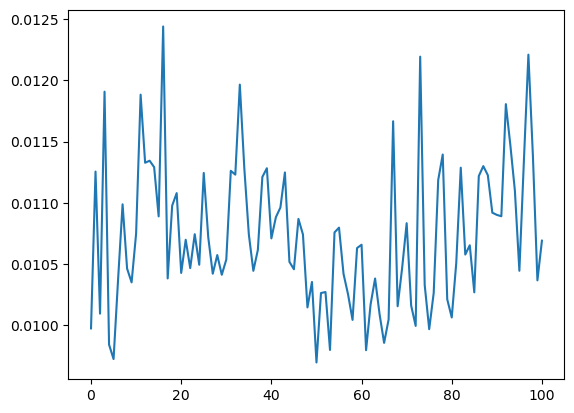

In [206]:
# Same genetic algorithm without individual visualization

# Scenario 1: Small

# 10-20 customer locations 


CUSTOMERS = [(0, 0), (1, 5), (2, 2), 
             (3, 8), (5, 5), (6, 1), 
             (8, 3), (8, 1), (8, 0), 
             (3, 2), (1, 3), (0, 3),
             (4, 2), (4, 0), (1, 2),
            ]
POP_SIZE = 50

GEN = 100

N_VEHICLES = 12
import matplotlib.pyplot as plt


def genetic_algorithm():
    """
    Runs the genetic algorithm for the vehicle route optimization problem.
    
    This function initializes a population, evolves it over several generations,
    and prints the state of the population at each step.
    """
    population = [create_individual() for _ in range(POP_SIZE)]
    best_fitness = []
    fitness_init = [fitness(p)[1] for p in population]
    
    best_fit = [np.max(fitness_init)]
        
    
    
    
    for generation in range(GEN):
        
        
        new_population = []
        
        #print("\nCrossover and Mutation:")
        for i in range(0, POP_SIZE, 2):
            parent1, parent2 = random.sample(population, 2)
           
            child1, child2 = crossover(parent1, parent2)
            
            mutated_child1 = mutate(child1)
            
            new_population.extend([mutated_child1, mutate(child2)])
        
        
        population = new_population
        
        
        fitnesses = [fitness(p)[1] for p in population]
        
        best_fit.append(np.max(fitnesses))
        
        
    return best_fit

if __name__ == "__main__":
    fit = genetic_algorithm()
    plt.plot(fit)
    

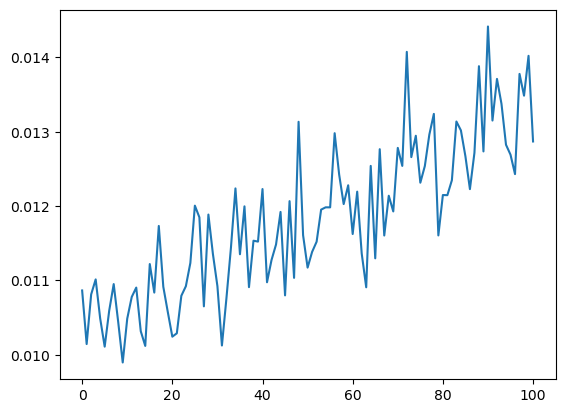

In [224]:

# ROULETTE WHEEL SELECTION
def roulette_pick(population):
    pop_fitness = [fitness(p)[1] for p in population]
    total_fit = np.sum(pop_fitness)
    prob = [fit/total_fit for fit in pop_fitness]
    selected = random.choices(population, weights = prob, k=2)
    return selected
    



def genetic_algorithm2():
    """
    Runs the genetic algorithm for the vehicle route optimization problem
    
    This function initializes a population, evolves it over several generations,
    and prints the state of the population at each step.
    """
    population = [create_individual() for _ in range(POP_SIZE)]
    best_fitness = []
    fitness_init = [fitness(p)[1] for p in population]
    
    best_fit = [np.max(fitness_init)]
        
    
    
    for generation in range(GEN):
       
        
        new_population = []
        
        for i in range(0, POP_SIZE, 2):
            parents = roulette_pick(population)
            child1, child2 = crossover(parents[0], parents[1])
            
            
            mutated_child1 = mutate(child1)
            
            new_population.extend([mutated_child1, mutate(child2)])
        
        
        
        
        
        population = new_population
        
        fitnesses = [fitness(p)[1] for p in population]
        
        best_fit.append(np.max(fitnesses))

    return best_fit

if __name__ == "__main__":
    fit = genetic_algorithm2()
    #print(fit)
    plt.plot(fit)
    

## COMMENT
# FITNESS VALUES ARE VERY CLOSE TOGETHER, SO THERE MIGHT BE NO SELECTION PRESSURE OR LITTLE SELECTION PRESSURE


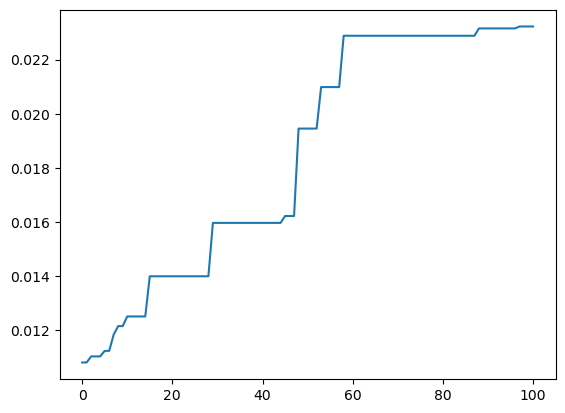

In [222]:


# ALGORITHM WITH PARENT SELECTION + ELITISM

def roulette_pick(population):
    pop_fitness = [fitness(p)[1] for p in population]
    total_fit = np.sum(pop_fitness)
    prob = [fit/total_fit for fit in pop_fitness]
    selected = random.choices(population, weights = prob, k=2)
    return selected
    


def genetic_algorithm3():
    """
    Runs the genetic algorithm for the VHR.
    
    This function initializes a population, evolves it over several generations,
    and prints the state of the population at each step.
    """
    population = [create_individual() for _ in range(POP_SIZE)]
    best_fitness = []
    fitness_init = [fitness(p)[1] for p in population]
    
    best_fit = [np.max(fitness_init)]
        
    
    
    for generation in range(GEN):
       
        
        new_population = []
        
        for i in range(0, POP_SIZE, 2):
            #parents = random.sample(population, 2)
            parents = roulette_pick(population)
            child1, child2 = crossover(parents[0], parents[1])
            
            
            mutated_child1 = mutate(child1)
            
            new_population.extend([mutated_child1, mutate(child2)])
        
        
        
        
        # keep top 2 parents 
        fitnesses = [fitness(p)[1] for p in population] 
        sorted_fitnesses = sorted(fitnesses, reverse = "True") 
        pop_top2 = [population[fitnesses.index(sorted_fitnesses[i])] for i in range(2)] 
        new_gen = pop_top2 

        # fill the rest of the population with fittest children
        children_fitnesses = [fitness(c)[1] for c in new_population] 
        sorted_children_fit = sorted(children_fitnesses, reverse = "True") 
        for i in range(len(population)-2): 
            new_gen.append(new_population[children_fitnesses.index(sorted_children_fit[i])]) 
        
        population = new_gen 

        
        fits = [fitness(p)[1] for p in population]
        
        
        best_fit.append(np.max(fits))

    return best_fit

if __name__ == "__main__":
    fit = genetic_algorithm3()
    plt.plot(fit)
    

In [38]:
# testing rank-based selection

def rank_crossover(population):
    pop_fitness = [fitness(p)[1] for p in population]
    sorted_indices = np.argsort(pop_fitness)[::-1]
    ranks = np.arange(1, len(population) + 1) 
    
    probs = (len(ranks) - ranks + 1) / np.sum(len(ranks) - ranks + 1)
    sorted_pop = [population[i] for i in sorted_indices]
    
    distances = [fitness(p)[0] for p in sorted_pop]
    
    print(distances)
    print(population)
    print(sorted_pop)
    print(probs)
    print(ranks)
    
    selected = random.choices(sorted_pop, weights=probs, k=2)
    return selected 

x1 = create_individual()
x2 = create_individual()
x3 = create_individual()
rank_crossover([x1,x2,x3])

[15.721349351738361, 17.31370849898476, 17.31370849898476]
[[[1, 0, 2], [0, 1, 1]], [[2, 1, 0], [0, 0, 0]], [[2, 1, 0], [0, 1, 0]]]
[[[2, 1, 0], [0, 0, 0]], [[2, 1, 0], [0, 1, 0]], [[1, 0, 2], [0, 1, 1]]]
[0.5        0.33333333 0.16666667]
[1 2 3]


[[[1, 0, 2], [0, 1, 1]], [[2, 1, 0], [0, 1, 0]]]

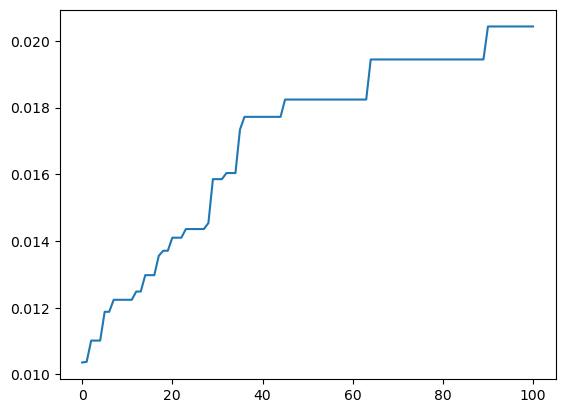

In [46]:
CUSTOMERS = [(0, 0), (1, 5), (2, 2), 
             (3, 8), (5, 5), (6, 1), 
             (8, 3), (8, 1), (8, 0), 
             (3, 2), (1, 3), (0, 3),
             (4, 2), (4, 0), (1, 2),
            ]

N_VEHICLES = 12

# ALGORITHM WITH PARENT SELECTION + ELITISM

# GENETIC ALGORITHM WITH RANK-BASED SELECTION (INSTEAD OF FITNESS)
def rank_selection(population):
    
    pop_fitness = [fitness(p)[1] for p in population]
    sorted_indices = np.argsort(pop_fitness)[::-1]
    ranks = np.arange(1, len(population) + 1) 
    
    probs = (len(ranks) - ranks + 1) / np.sum(len(ranks) - ranks + 1)
    
    sorted_pop = [population[i] for i in sorted_indices]    
   
    selected = random.choices(sorted_pop, weights=probs, k=2)

    return selected 



    


def genetic_algorithm_4():
    """
    Runs the genetic algorithm for the VHR.
    
    This function initializes a population, evolves it over several generations,
    and prints the state of the population at each step.
    """
    population = [create_individual() for _ in range(POP_SIZE)]
    best_fitness = []
    fitness_init = [fitness(p)[1] for p in population]
    
    best_fit = [np.max(fitness_init)]
        
    
    
    for generation in range(GEN):
       
        
        new_population = []
        
        for i in range(0, POP_SIZE, 2):
            #parents = random.sample(population, 2)
            parents = rank_selection(population)
            child1, child2 = crossover(parents[0], parents[1])
            
            
            mutated_child1 = mutate(child1)
            
            new_population.extend([mutated_child1, mutate(child2)])
        
        
        
        
        # keep top 2 parents 
        fitnesses = [fitness(p)[1] for p in population] 
        sorted_fitnesses = sorted(fitnesses, reverse = "True") 
        pop_top2 = [population[fitnesses.index(sorted_fitnesses[i])] for i in range(2)] 
        new_gen = pop_top2 

        # fill the rest of the population with fittest children
        children_fitnesses = [fitness(c)[1] for c in new_population] 
        sorted_children_fit = sorted(children_fitnesses, reverse = "True") 
        for i in range(len(population)-2): 
            new_gen.append(new_population[children_fitnesses.index(sorted_children_fit[i])]) 
        
        population = new_gen 

        
        fits = [fitness(p)[1] for p in population]
        
        best_fit.append(np.max(fits))

    return best_fit

if __name__ == "__main__":
    fit = genetic_algorithm_4()
    plt.plot(fit)
    

Final algorithm!

In [1]:
def create_individual():
    vehicle = list(np.random.randint(N_VEHICLES, size=(len(CUSTOMERS))))
    schedule = random.sample(range(len(CUSTOMERS)), len(CUSTOMERS))
    individual = [schedule, vehicle]

    return individual

In [2]:
def get_distance(route):
    if len(route) == 0:
        return 0
        
    x1,y1 = DEPOT_LOCATION
    x2,y2 = CUSTOMERS[route[0]]

    route_distance = ((x1-x2)**2 + (y1-y2)**2)**0.5

    
    for i in range(1, len(route)):
        route_distance += ((CUSTOMERS[route[i]][0] - CUSTOMERS[route[i-1]][0])**2 + 
                           (CUSTOMERS[route[i]][1] - CUSTOMERS[route[i-1]][1])**2)**0.5

    # the vehicle returns to depot
    x3, y3 = CUSTOMERS[route[len(route)-1]]
    route_distance += ((x1-x3)**2 + (y1-y3)**2)**0.5
    return route_distance

# fitness calculation: for each vehicle, calculate the distance it travels 
# and add them together
# when distance decreases, 1/distance increases
# since the goal is distance minimization 
# fitness is calculated as 1/distance

def fitness(individual):
    
    # route of each vehicle
    routes = [[] for i in range(N_VEHICLES)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)
        
    distance = 0 
    for route in routes:
        distance += get_distance(route)
    return distance, 1/distance
    
    


In [3]:
# CROSSOVER

# individual: [[route][vehicles]]
# [route] -> Permutation
# [vehicles] -> INTEGERS

# parents crossover: crossover for routes + crossover for vehicles


# order_crossover adapted from Lab 1 
def order_crossover(route1, route2):
    start, end = sorted(random.sample(range(len(route1)), 2))
    #start, end = 2,7
    child = [-1] * len(route1)
    child[start:end] = route1[start:end]
    pointer = end
    for customer in route2:
        if customer not in child:
            child[pointer] = customer
            pointer = (pointer + 1) % len(child)
    return child, (start, end)


# Uniform crossover for vehicles
# each gene is treated independently
# for each gene, choosing randomly from which parent to take the genes from
def uniform_crossover(vehicles1, vehicles2):
    
    child1 = []
    child2 = []

    for v1, v2 in zip(vehicles1, vehicles2):
        if random.random() < 0.5:
            child1.append(v1)
            child2.append(v2)
        else:
            child2.append(v1)
            child1.append(v2)
            
    return child1, child2
        
    


def crossover(parent1, parent2):
    
    child_route1, _ = order_crossover(parent1[0], parent2[0])
    child_route2, _ = order_crossover(parent2[0], parent1[0])
    
    child_vehicles1, child_vehicles2 = uniform_crossover(parent1[1], parent2[1])
    
    child1 = [child_route1, child_vehicles1]
    child2 = [child_route2, child_vehicles2]
    
    return child1, child2
    


    

In [4]:
# MUTATION

# MUTATION CAN BE route mutation or vehicles mutation

# function for route mutation 
# adapted from lab 1
# randomly swap two customer locations
def mutate_routes(route):
    i, j = random.sample(range(len(route)), 2)
    route[i], route[j] = route[j], route[i]
    return route


# function for vehicles mutation
# random resetting
# in each position, with a probability
# replace with a new vehicle value 
# from the list of admissible values

def mutate_vehicles(vehicles, mutation_prob):
    mutated = vehicles.copy()
    for i in range(len(mutated)):
        if random.random() < mutation_prob:
            old_v = vehicles[i]
            mutated[i] = random.choice([v for v in range(N_VEHICLES) if v != old_v])
    return mutated

# function to pick which part of the individual is mutated    
def pick_mutation(individual, mutation_prob):
    
    route, vehicles = individual[0], individual[1]
    
    if random.random() < 0.5:
        route = mutate_routes(route)
        
    
    else:
        vehicles = mutate_vehicles(vehicles, mutation_prob)
    return [route, vehicles]


# function to decide if individual is mutated     
def mutate(individual, mutation_prob):

    
    if random.random() < mutation_prob:
        mutated = pick_mutation(individual, mutation_prob)
        return mutated
        
    return individual
        
        
    

In [5]:
# ALGORITHM WITH PARENT SELECTION + ELITISM

# GENETIC ALGORITHM WITH RANK-BASED SELECTION (INSTEAD OF FITNESS)
def rank_selection(population):
    
    pop_fitness = [fitness(p)[1] for p in population]
    sorted_indices = np.argsort(pop_fitness)[::-1]
    ranks = np.arange(1, len(population) + 1) 
    
    probs = (len(ranks) - ranks + 1) / np.sum(len(ranks) - ranks + 1)
    
    sorted_pop = [population[i] for i in sorted_indices]    
   
    selected = random.choices(sorted_pop, weights=probs, k=2)

    return selected 



    


def genetic_algorithm_4(mutation_prob, crossover_prob):
    """
    Runs the genetic algorithm for the VHR.
    
    This function initializes a population, evolves it over several generations,
    and prints the state of the population at each step.
    """
    population = [create_individual() for _ in range(POP_SIZE)]
    best_fitness = []
    fitness_init = [fitness(p)[1] for p in population]
    
    best_fit = [np.max(fitness_init)]
        
    
    
    for generation in range(GEN):
       
        
        new_population = []
        
        for i in range(0, POP_SIZE, 2):
            #parents = random.sample(population, 2)
            parents = rank_selection(population)
            if random.random() < crossover_prob:
                child1, child2 = crossover(parents[0], parents[1])
                
            else:
                child1, child2 = parents[0], parents[1]
            
            
            
            mutated_child1 = mutate(child1, mutation_prob)
            
            new_population.extend([mutated_child1, mutate(child2, mutation_prob)])
        
        
        
        
        # keep top 2 parents 
        fitnesses = [fitness(p)[1] for p in population] 
        sorted_fitnesses = sorted(fitnesses, reverse = "True") 
        pop_top2 = [population[fitnesses.index(sorted_fitnesses[i])] for i in range(2)] 
        new_gen = pop_top2 

        # fill the rest of the population with fittest children
        children_fitnesses = [fitness(c)[1] for c in new_population] 
        sorted_children_fit = sorted(children_fitnesses, reverse = "True") 
        for i in range(len(population)-2): 
            new_gen.append(new_population[children_fitnesses.index(sorted_children_fit[i])]) 
        
        population = new_gen 

        
        fits = [fitness(p)[1] for p in population]
        
        best_fit.append(np.max(fits))

    return best_fit



In [13]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt

#Scenario small, instance 1

# Customer locations
DEPOT_LOCATION = (0,0)
CUSTOMERS = [(4, 4), (2, 2), 
             (3, 4), (6, 6),
             (8, 9), (9, 1),
             (4, 8), (5, 2), 
             (8, 4), (3, 6),
             (8, 6), (9, 3)
            ]


# number of vehicles
N_VEHICLES = 5


Total runtime of all cells: 0.83 seconds


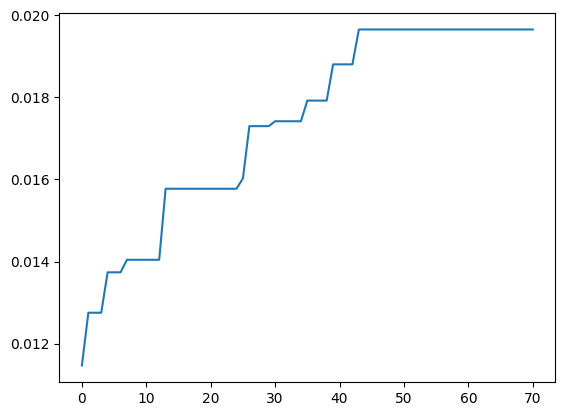

In [14]:
POP_SIZE = 60

GEN = 70

mutation_prob = 0.1

crossover_prob = 0.9

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 1.73 seconds


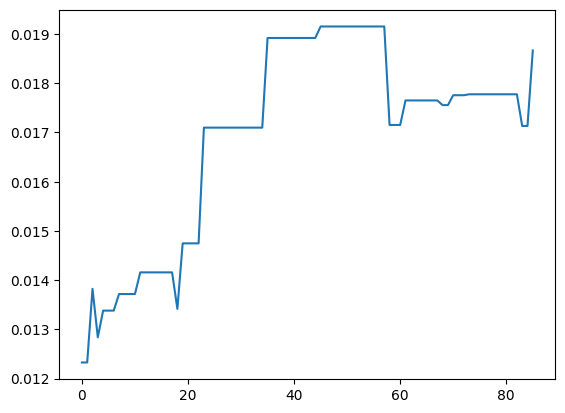

In [15]:
POP_SIZE = 75

GEN = 85

mutation_prob = 0.3

crossover_prob = 0.8

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 2.96 seconds


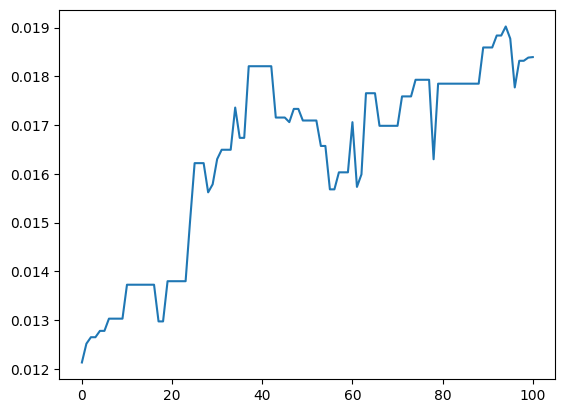

In [16]:
POP_SIZE = 90

GEN = 100

mutation_prob = 0.5

crossover_prob = 0.7

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

In [18]:
import time

#Scenario small, instance 2

# Customer locations
DEPOT_LOCATION = (0,0)
CUSTOMERS = [(4, 4), (2, 2), 
             (3, 4), (6, 6),
             (8, 9), (9, 1),
             (4, 8), (5, 2), 
             (8, 4), (3, 6),
             (8, 6), (9, 3),
             (4, 5), (3, 7), 
             (8, 4), (9, 4),
             (8, 2), (9, 6)
            ]


# number of vehicles
N_VEHICLES = 8

Total runtime of all cells: 1.22 seconds


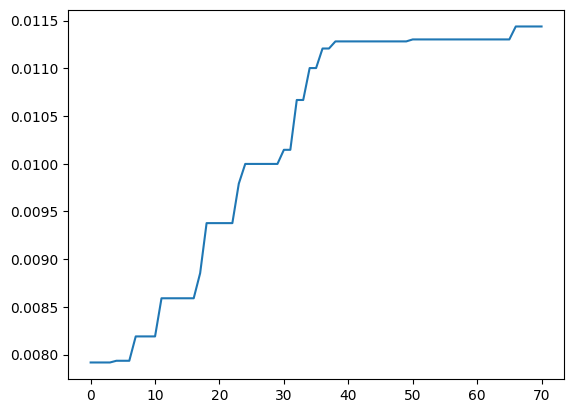

In [19]:
POP_SIZE = 60

GEN = 70

mutation_prob = 0.1

crossover_prob = 0.9

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 2.31 seconds


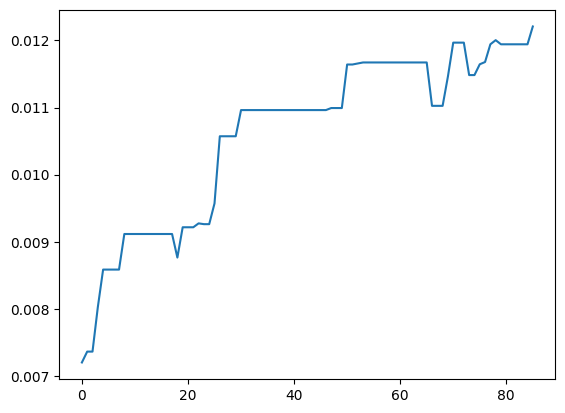

In [20]:
POP_SIZE = 75

GEN = 85

mutation_prob = 0.3

crossover_prob = 0.8

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 4.06 seconds


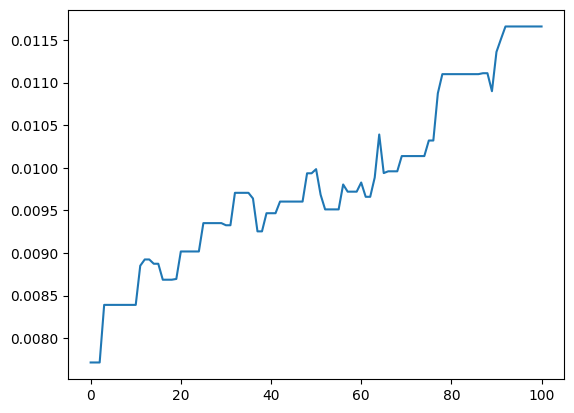

In [21]:
POP_SIZE = 90

GEN = 100

mutation_prob = 0.5

crossover_prob = 0.7

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

In [22]:
import time

#Scenario medium, instance 1

# Customer locations
DEPOT_LOCATION = (0,0)
CUSTOMERS = [(4, 4), (2, 2), 
             (3, 4), (6, 6),
             (8, 9), (9, 1),
             (4, 8), (5, 2), 
             (8, 4), (3, 6),
             (8, 6), (9, 3),
             (4, 5), (3, 7), 
             (8, 4), (9, 4),
             (8, 2), (9, 6),
             (7, 4), (5, 5)
            ]


# number of vehicles
N_VEHICLES = 13

Total runtime of all cells: 1.59 seconds


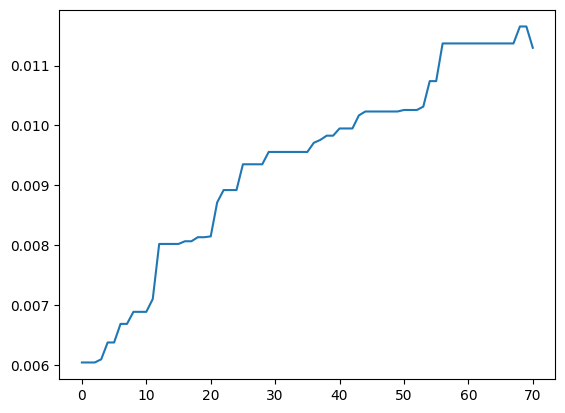

In [23]:
POP_SIZE = 60

GEN = 70

mutation_prob = 0.1

crossover_prob = 0.9

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 2.89 seconds


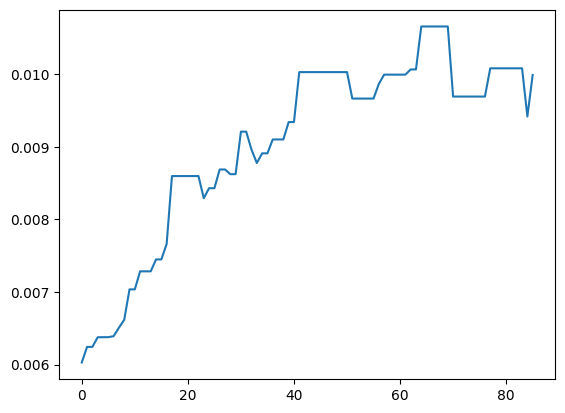

In [24]:
POP_SIZE = 75

GEN = 85

mutation_prob = 0.3

crossover_prob = 0.8

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 4.57 seconds


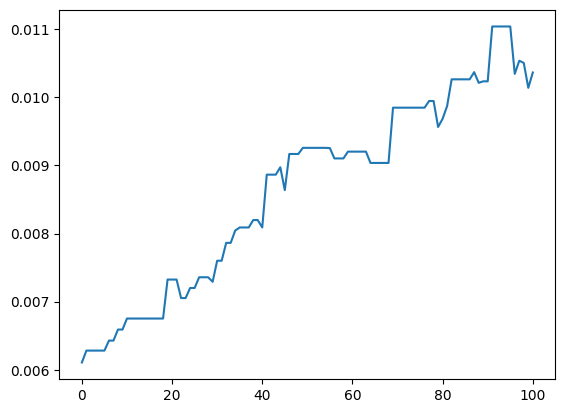

In [25]:
POP_SIZE = 90

GEN = 100

mutation_prob = 0.5

crossover_prob = 0.7

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

In [26]:
import time

#Scenario medium, instance 2

# Customer locations
DEPOT_LOCATION = (0,0)
CUSTOMERS = [(4, 4), (2, 2), 
             (3, 4), (6, 6),
             (8, 9), (9, 1),
             (4, 8), (5, 2), 
             (8, 4), (3, 6),
             (8, 6), (9, 3),
             (4, 5), (3, 7), 
             (8, 4), (9, 4),
             (8, 2), (9, 6),
             (7, 4), (5, 5),
             (4, 6), (1, 5), 
             (4, 3), (1, 2),
             (2, 3), (1, 6),
             (3, 2), (2, 5)
            ]


# number of vehicles
N_VEHICLES = 22

Total runtime of all cells: 2.24 seconds


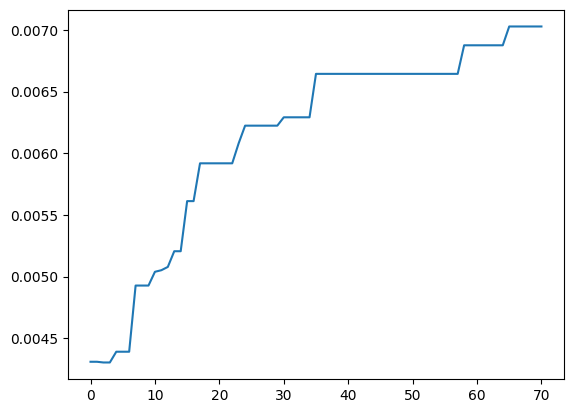

In [27]:
POP_SIZE = 60

GEN = 70

mutation_prob = 0.1

crossover_prob = 0.9

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 4.10 seconds


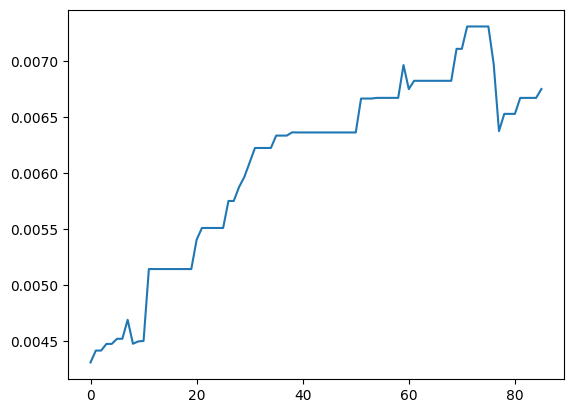

In [28]:
POP_SIZE = 75

GEN = 85

mutation_prob = 0.3

crossover_prob = 0.8

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 6.79 seconds


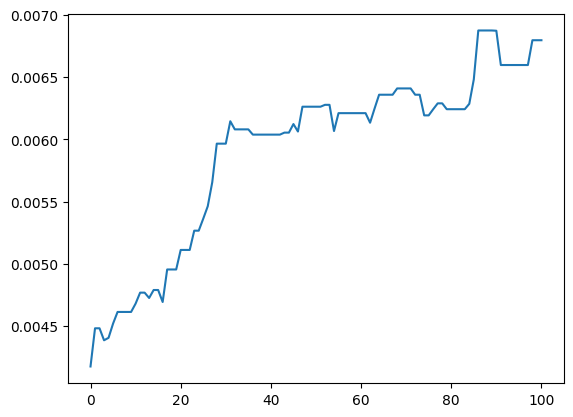

In [29]:
POP_SIZE = 90

GEN = 100

mutation_prob = 0.5

crossover_prob = 0.7

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

In [30]:
import time

#Scenario big, instance 1

# Customer locations
DEPOT_LOCATION = (0,0)
CUSTOMERS = [(4, 4), (2, 2), 
             (3, 4), (6, 6),
             (8, 9), (9, 1),
             (4, 8), (5, 2), 
             (8, 4), (3, 6),
             (8, 6), (9, 3),
             (4, 5), (3, 7), 
             (8, 4), (9, 4),
             (8, 2), (9, 6),
             (7, 4), (5, 5),
             (4, 6), (1, 5), 
             (4, 3), (1, 2),
             (2, 3), (1, 6),
             (3, 2), (2, 5)
            ]


# number of vehicles
N_VEHICLES = 30

Total runtime of all cells: 2.39 seconds


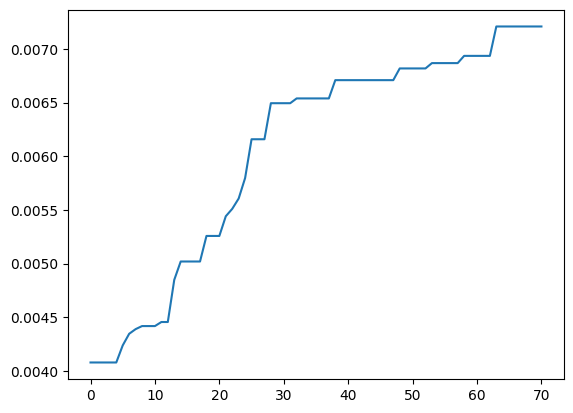

In [31]:
POP_SIZE = 60

GEN = 70

mutation_prob = 0.1

crossover_prob = 0.9

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 4.42 seconds


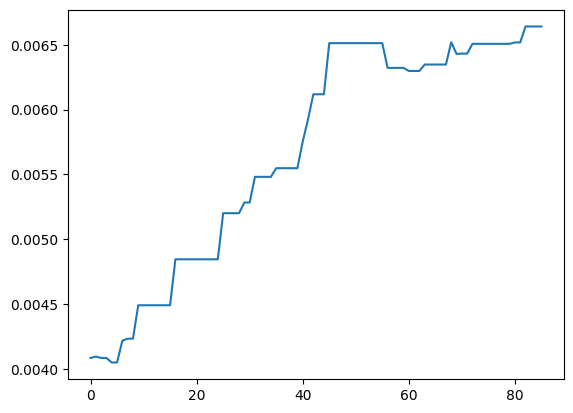

In [32]:
POP_SIZE = 75

GEN = 85

mutation_prob = 0.3

crossover_prob = 0.8

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 7.91 seconds


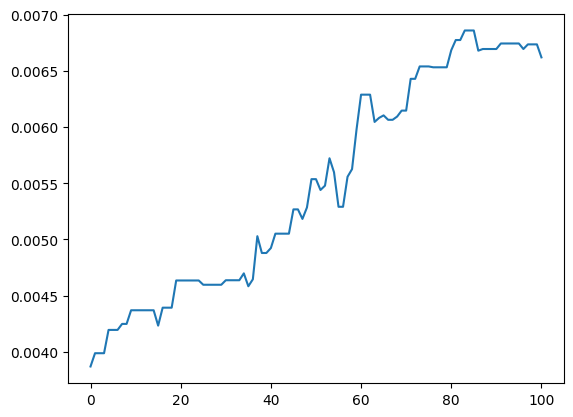

In [33]:
POP_SIZE = 90

GEN = 100

mutation_prob = 0.5

crossover_prob = 0.7

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

In [34]:
import time

#Scenario big, instance 2

# Customer locations
DEPOT_LOCATION = (0,0)
CUSTOMERS = [(4, 4), (2, 2), 
             (3, 4), (6, 6),
             (8, 9), (9, 1),
             (4, 8), (5, 2), 
             (8, 4), (3, 6),
             (8, 6), (9, 3),
             (4, 5), (3, 7), 
             (8, 4), (9, 4),
             (8, 2), (9, 6),
             (7, 4), (5, 5),
             (4, 6), (1, 5), 
             (4, 3), (1, 2),
             (2, 3), (1, 6),
             (3, 2), (2, 5),
             (5, 4), (4, 6),
             (7, 6), (3, 3),
             (7, 5), (7, 3), 
             (5, 9), (9, 6),
             (9, 0), (8, 0),
             (7, 0), (6, 0),
             (5, 0), (4, 0), 
             (3, 0), (2, 0),
             (1, 0), (10, 1),
             (10, 2), (10, 3)
            ]


# number of vehicles
N_VEHICLES = 45

Total runtime of all cells: 3.74 seconds


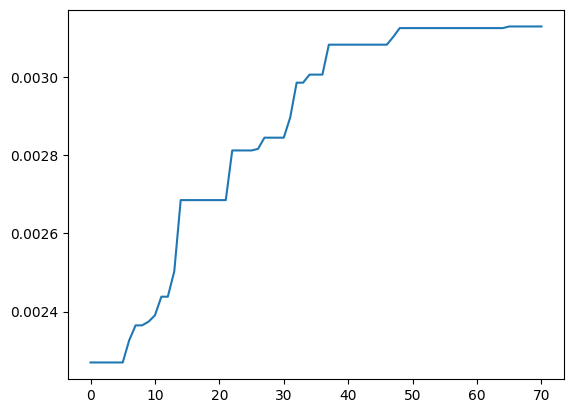

In [35]:
POP_SIZE = 60

GEN = 70

mutation_prob = 0.1

crossover_prob = 0.9

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 7.42 seconds


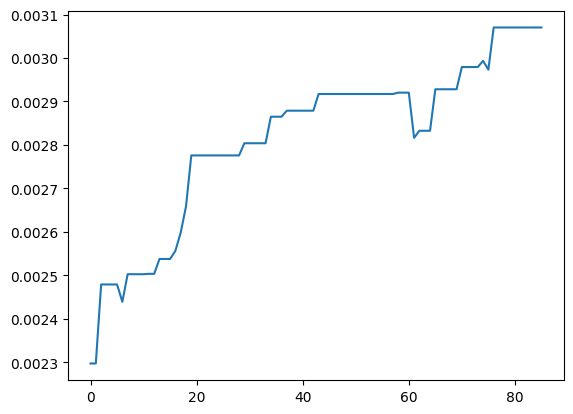

In [36]:
POP_SIZE = 75

GEN = 85

mutation_prob = 0.3

crossover_prob = 0.8

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)

Total runtime of all cells: 12.08 seconds


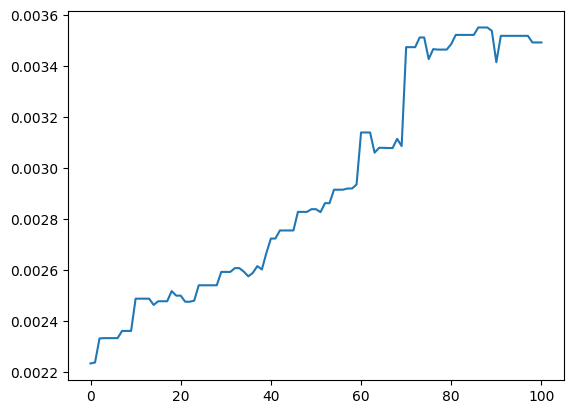

In [37]:
POP_SIZE = 90

GEN = 100

mutation_prob = 0.5

crossover_prob = 0.7

start_time = time.perf_counter()

fit = genetic_algorithm_4(mutation_prob, crossover_prob)

end_time = time.perf_counter()
print(f"Total runtime of all cells: {end_time - start_time:.2f} seconds")

plt.plot(fit)